In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
# conda install -c fastai fastai
import fastai
print("fastai: ",fastai.__version__)
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

fastai:  1.0.46
Torch:  1.0.1.post2
Torchvision:  0.2.1
sklearn:  0.20.2
Python:  3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [3]:
!nvidia-smi

Fri Mar 15 16:39:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   44C    P8    18W / 250W |    546MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

GPU:  GeForce GTX 1080 Ti


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
PATH = '../../../../../data/amazon_space/'

In [7]:
import os
print(os.listdir(PATH))

['sample_submission_v2.csv', 'test-jpg', 'test-jpg-additional.tar', 'train_v2.csv.zip', 'train-tif-v2.tar.7z', 'train-jpg.tar', 'Kaggle-planet-test-tif.torrent', 'test-jpg-additional', 'models', 'train-jpg.tar.7z', 'sample_submission_v2.csv.zip', '__MACOSX', 'test-jpg-additional.tar.7z', 'test-jpg.tar.7z', 'train-jpg', 'test-jpg.tar', 'test_v2_file_mapping.csv.zip', 'train_v2.csv', 'test_v2_file_mapping.csv', 'Kaggle-planet-train-tif.torrent', 'test-tif-v2.tar.7z']


In [8]:
df = pd.read_csv(PATH+'train_v2.csv')

In [9]:

df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [10]:
df_t = pd.read_csv(PATH+'sample_submission_v2.csv')
df_t.head()

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [11]:
from fastai.vision import *

In [12]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [13]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [14]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [15]:
data.train_dl.batch_size

64

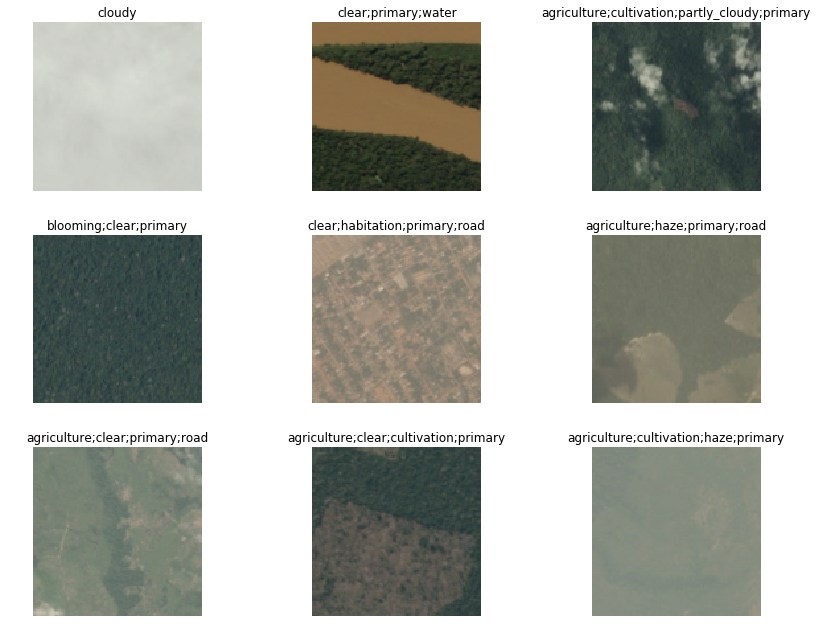

In [16]:
data.show_batch(rows=3, figsize=(12,9))

In [17]:
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [18]:
data.train_ds[0]

(Image (3, 128, 128), <fastai.core.MultiCategory at 0x7f5c0dcb5588>)

To create a Learner we use the same function as in lesson 1. Our base architecture is resnet34 again, 
but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. 
In lesson 1, we determined the predicition for a given class 
by picking the final activation that was the biggest, but here, each activation can be 0. or 1. 
accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

In [17]:
#arch = models.resnet101
arch = models.resnet152

In [18]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


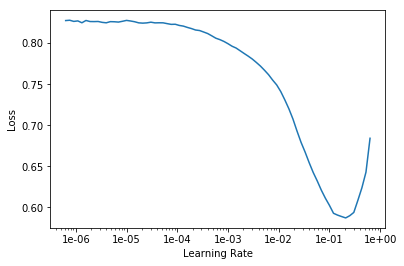

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr = 3e-2

In [27]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.recorder.plot_losses()

In [28]:
learn.save('stage-1-rn101')

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


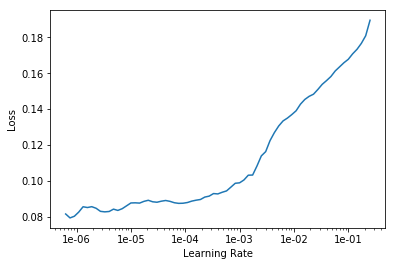

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:

learn.fit_one_cycle(5, slice(5e-6, lr/5))

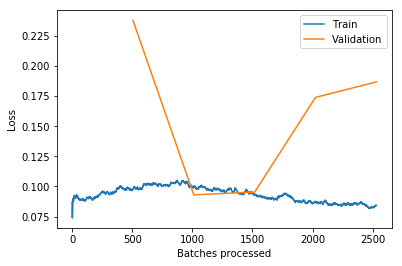

In [32]:
learn.recorder.plot_losses()

In [33]:
learn.save('stage-2-rn151')

In [34]:
learn.load('stage-2-rn151')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: ../../../../../data/amazon_space;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: ../../../../../data/amazon_space;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, st

In [20]:
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))

In [21]:
data.train_dl.batch_size

16

In [22]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [38]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


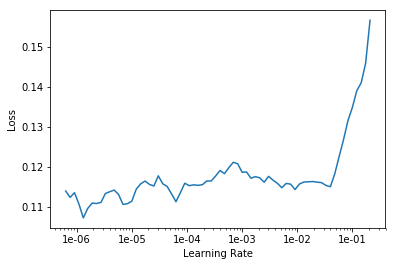

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr=1e-4

In [41]:
learn.fit_one_cycle(5, slice(lr))

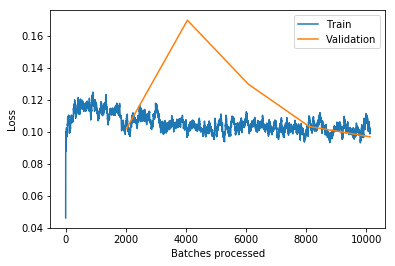

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.save('stage-1-256-rn151')

In [58]:
learn.load('stage-1-256-rn151')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: ../../../../../data/amazon_space;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: ../../../../../data/amazon_space;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, st

In [59]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


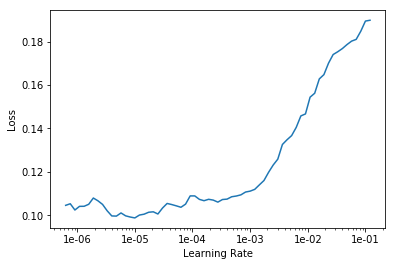

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(5, slice(1e-6, lr/10))

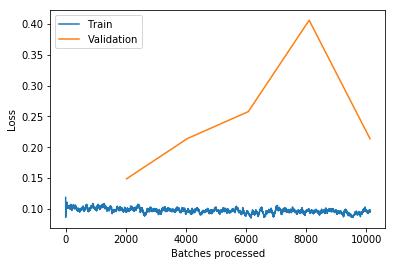

In [62]:
learn.recorder.plot_losses()

In [63]:
learn.save('stage-2-256-rn151')

In [23]:
learn.load('stage-2-256-rn151')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: ../../../../../data/amazon_space;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: ../../../../../data/amazon_space;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, st

In [30]:
learn.export()

In [36]:
learn.path

PosixPath('../../../../../data/amazon_space')

In [24]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [25]:
data.c

17

In [53]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

False

In [55]:
#interp.plot_top_losses(9, figsize=(15,11))

In [57]:
#interp.most_confused(min_val=2)

In [ ]:
## TESTING

In [26]:
test = ImageList.from_folder(PATH+'test-jpg').add(ImageList.from_folder(PATH+'test-jpg-additional'))
len(test)

61191

In [32]:
!ls

'Amazon Space.ipynb'


In [37]:
learn = load_learner(path=learn.path, test=test)

In [38]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [40]:
labelled_preds[:5]

['agriculture clear primary road water',
 'haze primary water',
 'cloudy partly_cloudy primary',
 'artisinal_mine clear primary water',
 'artisinal_mine partly_cloudy primary water']

In [41]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [42]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [43]:
df.head()

image_name                                        tags
0  test_40462        agriculture clear primary road water
1  test_32371                          haze primary water
2   test_9990                cloudy partly_cloudy primary
3  test_17367          artisinal_mine clear primary water
4  test_35773  artisinal_mine partly_cloudy primary water

In [44]:
df.to_csv(PATH+'submission.csv', index=False)

In [46]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {PATH+'submission.csv'} -m "My submission"

100%|███████████████████████████████████████| 2.20M/2.20M [00:03<00:00, 624kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

In [49]:
# predict single image
doc(learn.predict)

In [136]:
learn.data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

agriculture clear habitation primary road


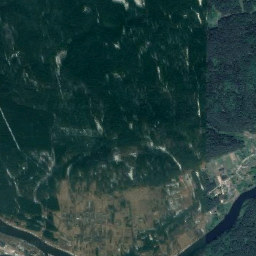

In [135]:
img = open_image(PATH+'sat1.png')
output, pred_classes, pred_prob = learn.predict(img)
labelled_pred = ' '.join(learn.data.classes[i] for i,p in enumerate(pred_classes.numpy().tolist()) if p > 0.0) 
print(labelled_pred); img

clear habitation primary road


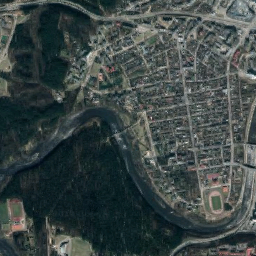

In [137]:
img = open_image(PATH+'sat2.png')
output, pred_classes, pred_prob = learn.predict(img)
labelled_pred = ' '.join(learn.data.classes[i] for i,p in enumerate(pred_classes.numpy().tolist()) if p > 0.0) 
print(labelled_pred); img

clear primary water


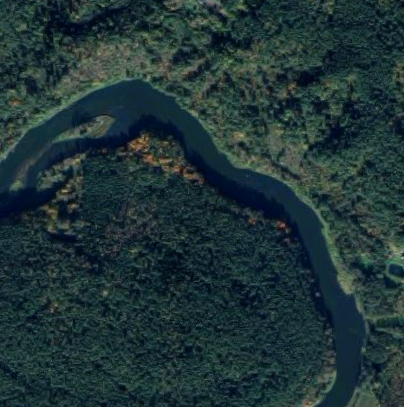

In [134]:
img = open_image(PATH+'sat3.png')
output, pred_classes, pred_prob = learn.predict(img)
labelled_pred = ' '.join(learn.data.classes[i] for i,p in enumerate(pred_classes.numpy().tolist()) if p > 0.0) 
print(labelled_pred); img

agriculture clear habitation primary road


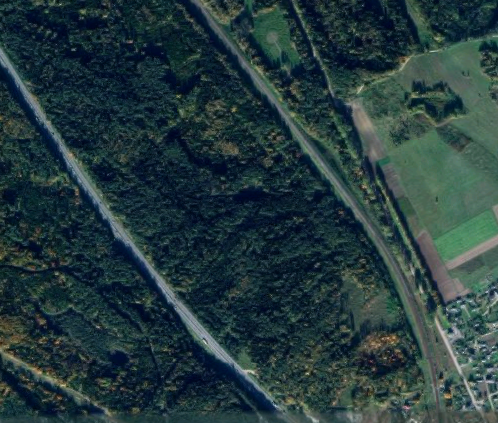

In [139]:
img = open_image(PATH+'sat4.png')
output, pred_classes, pred_prob = learn.predict(img)
labelled_pred = ' '.join(learn.data.classes[i] for i,p in enumerate(pred_classes.numpy().tolist()) if p > 0.0) 
print(labelled_pred); img

clear habitation primary road


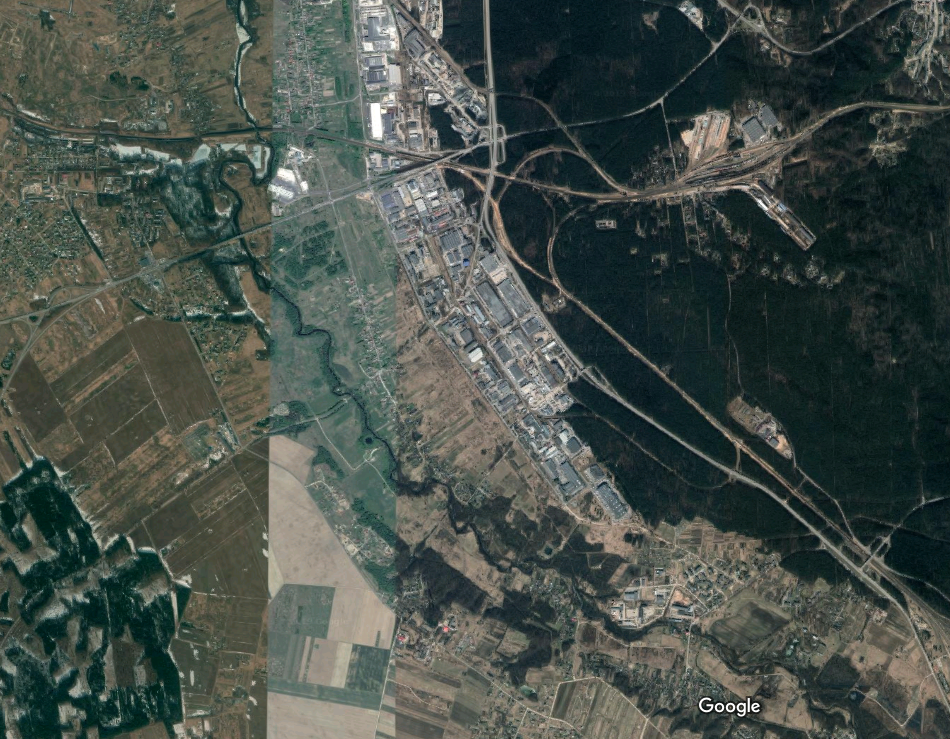

In [140]:
img = open_image(PATH+'sat5.png')
output, pred_classes, pred_prob = learn.predict(img)
labelled_pred = ' '.join(learn.data.classes[i] for i,p in enumerate(pred_classes.numpy().tolist()) if p > 0.0) 
print(labelled_pred); img

In [142]:
img.shape

torch.Size([3, 739, 950])